In [2]:
import os
import multiprocess as mp
import pandas as pd
from pymongo import MongoClient
from typing import List, Dict, Set
from datetime import datetime, timedelta
from dataclasses import dataclass, asdict
from pymongo.cursor import Cursor
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from gryft.scanning.types import CVE, Component

import dotenv
dotenv.load_dotenv(".env", override=True) # Defines MONGO_URI

True

In [3]:
@dataclass(frozen=True)
class Remediation:
    cve: CVE
    first_seen_at: datetime
    remediated_at: datetime


def _extract_cves(scan: Dict) -> Set[CVE]:
    cves = []
    for cve in scan["cves"]:
        # Handle case where component is not provided
        component_dict = {"name": None, "version": None, "type_": None}
        component_dict = cve.get("component", component_dict)
        component = Component(**component_dict)
        
        cve = CVE(id=cve["id"],
                  severity=cve["severity"],
                  fix_state=cve["fix_state"],
                  component=component)
        cves.append(cve)
    return set(cves)


def _init_active_table(first_scan: Dict) -> Dict[CVE, datetime]:
    cves = _extract_cves(first_scan)
    return {c: first_scan["scan_start"] for c in cves}


def _get_remediated_cves(discovered: set[CVE], active: Dict[CVE, datetime]) -> Set[CVE]:
    past = set(active.keys())
    return past - discovered


def _get_new_cves(discovered: set[CVE], active: Dict[CVE, datetime]) -> Set[CVE]:
    past = set(active.keys())
    return discovered - past


def find_remediations(scans: Cursor) -> List[Remediation]:
    active = None
    last_scan = None
    rems = []

    for s in scans:
        if active is None:
            active = _init_active_table(s)
        else:
            discovered_cves = _extract_cves(s)
            remediated_cves = _get_remediated_cves(discovered_cves, active)
            for cve in remediated_cves:
                r = Remediation(cve, active[cve], s["scan_start"])
                rems.append(r)
                del active[cve]
            new_cves = _get_new_cves(discovered_cves, active)
            for cve in new_cves:
                active[cve] = s["scan_start"]
        last_scan = s

    #Consider all remaining CVEs in the table "remediated"
    if active is not None:
        for cve, first_seen_at in active.items():
            # TODO: Update this to label non remediated CVEs
            r = Remediation(cve, first_seen_at, last_scan["scan_start"])
            rems.append(r)

    return rems

In [4]:
def process_image(image: dict) -> pd.DataFrame:
    query = {
        "registry": image["registry"],
        "repository": image["repository"],
        "tag": image["tag"]
    }
    scans = db["cves"].find(query)
    rems = find_remediations(scans)
    df = pd.DataFrame(map(asdict, rems))
    for col in ["registry", "repository", "tag"]:
        df[col] = image[col]
    df["labels"] = "".join(image["labels"])
    return df


client = MongoClient(os.environ["MONGO_URI"])
db = client["gallery"]

images = list(db["images"].find())

with mp.Pool(mp.cpu_count()) as pool:
    dfs = list(tqdm(pool.imap_unordered(process_image, images),
                    desc=f"Collecting remediations",
                    total=len(images)))

rems_df = pd.concat(dfs, axis=0, ignore_index=True)

# Expand CVE column
expanded_df = pd.json_normalize(rems_df["cve"])
rems_df = pd.concat([rems_df.drop(columns=["cve"]), expanded_df], axis=1)

# Create remediation time (rtime) column
rems_df["rtime"] = (rems_df["remediated_at"] - rems_df["first_seen_at"])
rems_df["rtime"] = rems_df["rtime"].dt.total_seconds() / 3600

In [5]:
SECOND_HOUR = datetime(2024, 3, 28, 5)
rems_df_filtered = rems_df[rems_df["first_seen_at"] >= SECOND_HOUR]

In [8]:
# Plot Remediations

def get_label_stats(label: str, df: pd.DataFrame) -> pd.DataFrame:
    label_df = df[df["labels"].str.contains(label)]
    rtime = label_df["rtime"]
    return pd.DataFrame({"label": label,
                         "num-rems": rtime.count(),
                         "rtime-ave": rtime.mean() / 24,
                         "rtime-std": rtime.std() / 24}, index=[0])


def get_stats(labels: List[str], df: pd.DataFrame) -> pd.DataFrame:
    dfs = [get_label_stats(l, df) for l in labels]
    return pd.concat(dfs, axis=0, ignore_index=True)


def get_series(label: str, df: pd.DataFrame) -> np.ndarray:
    label_df = df[df["labels"].str.contains(label)]
    return label_df["rtime"].to_numpy()


labels = ["cgr-public", "docker-official", "ubi"]

stats = get_stats(labels, rems_df_filtered)
print(stats)
# for l in labels:
#     x = get_series(l, rems_df) / 24
#     plt.hist(x, label=l)

# plt.legend()
# plt.xlabel("Remediation Time (Days)")
# plt.ylabel("Num CVEs")

             label  num-rems  rtime-ave  rtime-std
0       cgr-public        20   3.370479   1.058707
1  docker-official     10011   3.340395   1.093089
2              ubi     27318   3.561382   0.906097


Text(0, 0.5, 'Number of CVEs')

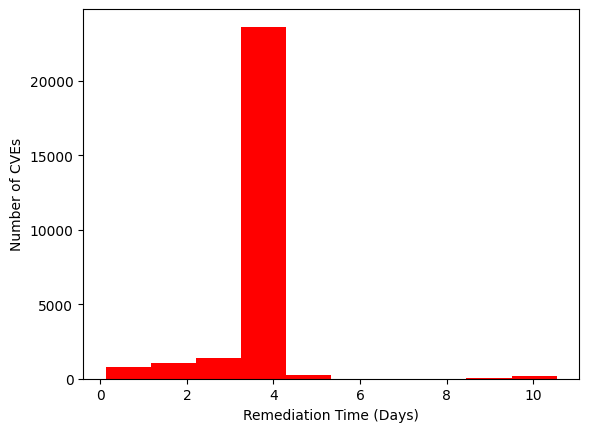

In [23]:
x = get_series("ubi", rems_df_filtered) / 24
plt.hist(x, color="red")
plt.xlabel("Remediation Time (Days)")
plt.ylabel("Number of CVEs")

In [15]:
images

[{'_id': ObjectId('66049fecd8cecdbff4d94ec9'),
  'publisher': 'docker',
  'registry': 'docker.io',
  'repository': 'nginx',
  'tag': 'latest',
  'labels': ['docker-official']},
 {'_id': ObjectId('66049fecd8cecdbff4d94eca'),
  'publisher': 'docker',
  'registry': 'docker.io',
  'repository': 'postgres',
  'tag': 'latest',
  'labels': ['docker-official']},
 {'_id': ObjectId('66049fecd8cecdbff4d94ecb'),
  'publisher': 'docker',
  'registry': 'docker.io',
  'repository': 'alpine',
  'tag': 'latest',
  'labels': ['docker-official']},
 {'_id': ObjectId('66049fecd8cecdbff4d94ecc'),
  'publisher': 'docker',
  'registry': 'docker.io',
  'repository': 'memcached',
  'tag': 'latest',
  'labels': ['docker-official']},
 {'_id': ObjectId('66049fecd8cecdbff4d94ecd'),
  'publisher': 'docker',
  'registry': 'docker.io',
  'repository': 'redis',
  'tag': 'latest',
  'labels': ['docker-official']},
 {'_id': ObjectId('66049fecd8cecdbff4d94ece'),
  'publisher': 'docker',
  'registry': 'docker.io',
  'repos

In [42]:
def mean_rtime(rems_df: pd.DataFrame, label: str) -> float:
    label_df = rems_df[rems_df["labels"].str.contains(label)]
    return label_df["rtime"].mean(), label_df["rtime"].std()

labels = ["cgr-public"]
for l in labels:
    print(mean_rtime(rems_df, l))

TypeError: unsupported operand type(s) for /: 'tuple' and 'int'

In [17]:

rtime_df = rems_df.groupby(["registry", "repository", "tag"])["rtime"].mean().reset_index()

In [18]:
rtime_df.groupby(["registry"])["rtime"].mean().sort_values(ascending=True)

registry
cgr.dev    158.551216
Name: rtime, dtype: float64

In [29]:
print("Docker.io Official")
docker_mask = rtime_df["registry"] == "docker.io"
ubuntu_mask = rtime_df["repository"].str.contains("ubuntu")
rtime_df[docker_mask & ~ubuntu_mask]["rtime"].mean()

Docker.io Official


177.4936559408927

In [18]:
print("Docker.io Ubuntu Chiselled")
rtime_df[rtime_df["repository"].str.contains("ubuntu")]["rtime"].mean()

Docker.io Ubuntu Chiselled


201.80778568966485

In [11]:
rems_df

,registry,repository,tag,cve,first_seen_at,remediated_at,rtime
0,cgr.dev,chainguard/busybox,latest,"{'id': 'CVE-2023-42366', 'severity': 'medium',...",2024-03-28 04:08:33.912,2024-04-05 05:01:04.625,192.875198
1,cgr.dev,chainguard/busybox,latest,"{'id': 'CVE-2023-42365', 'severity': 'medium',...",2024-03-28 04:08:33.912,2024-04-10 14:02:04.950,321.891955
2,cgr.dev,chainguard/busybox,latest,"{'id': 'CVE-2023-42364', 'severity': 'medium',...",2024-03-28 04:08:33.912,2024-04-10 14:02:04.950,321.891955
3,cgr.dev,chainguard/busybox,latest,"{'id': 'CVE-2023-42363', 'severity': 'medium',...",2024-03-28 04:08:33.912,2024-04-10 14:02:04.950,321.891955
4,cgr.dev,chainguard/dive,latest,"{'id': 'GHSA-xw73-rw38-6vjc', 'severity': 'med...",2024-03-28 04:08:58.561,2024-04-01 19:02:52.826,110.898407
5,cgr.dev,chainguard/flux,latest,"{'id': 'GHSA-xw73-rw38-6vjc', 'severity': 'med...",2024-03-28 04:09:55.575,2024-04-01 19:04:06.645,110.903075
6,cgr.dev,chainguard/git,latest,"{'id': 'CVE-2023-42366', 'severity': 'medium',...",2024-03-28 04:08:43.666,2024-04-05 05:01:24.931,192.878129
7,cgr.dev,chainguard/git,latest,"{'id': 'CVE-2023-45288', 'severity': 'unknown'...",2024-04-06 05:02:30.630,2024-04-06 23:02:30.352,17.999923
8,cgr.dev,chainguard/git,latest,"{'id': 'CVE-2024-28182', 'severity': 'medium',...",2024-04-06 05:02:30.630,2024-04-07 01:02:30.822,20.000053
9,cgr.dev,chainguard/git,latest,"{'id': 'CVE-2023-42365', 'severity': 'medium',...",2024-03-28 04:08:43.666,2024-04-10 14:02:45.940,321.900632


In [12]:
rems_df

,registry,repository,tag,cve,first_seen_at,remediated_at,rtime
0,cgr.dev,chainguard/busybox,latest,"{'id': 'CVE-2023-42366', 'severity': 'medium',...",2024-03-28 04:08:33.912,2024-04-05 05:01:04.625,192.875198
1,cgr.dev,chainguard/busybox,latest,"{'id': 'CVE-2023-42365', 'severity': 'medium',...",2024-03-28 04:08:33.912,2024-04-10 14:02:04.950,321.891955
2,cgr.dev,chainguard/busybox,latest,"{'id': 'CVE-2023-42364', 'severity': 'medium',...",2024-03-28 04:08:33.912,2024-04-10 14:02:04.950,321.891955
3,cgr.dev,chainguard/busybox,latest,"{'id': 'CVE-2023-42363', 'severity': 'medium',...",2024-03-28 04:08:33.912,2024-04-10 14:02:04.950,321.891955
4,cgr.dev,chainguard/dive,latest,"{'id': 'GHSA-xw73-rw38-6vjc', 'severity': 'med...",2024-03-28 04:08:58.561,2024-04-01 19:02:52.826,110.898407
5,cgr.dev,chainguard/flux,latest,"{'id': 'GHSA-xw73-rw38-6vjc', 'severity': 'med...",2024-03-28 04:09:55.575,2024-04-01 19:04:06.645,110.903075
6,cgr.dev,chainguard/git,latest,"{'id': 'CVE-2023-42366', 'severity': 'medium',...",2024-03-28 04:08:43.666,2024-04-05 05:01:24.931,192.878129
7,cgr.dev,chainguard/git,latest,"{'id': 'CVE-2023-45288', 'severity': 'unknown'...",2024-04-06 05:02:30.630,2024-04-06 23:02:30.352,17.999923
8,cgr.dev,chainguard/git,latest,"{'id': 'CVE-2024-28182', 'severity': 'medium',...",2024-04-06 05:02:30.630,2024-04-07 01:02:30.822,20.000053
9,cgr.dev,chainguard/git,latest,"{'id': 'CVE-2023-42365', 'severity': 'medium',...",2024-03-28 04:08:43.666,2024-04-10 14:02:45.940,321.900632
